# Bat Hunting Calls

## CNN und FFNN mit Datenvorverarbeitung

_Joshua Reusch_, Lorenz Branner, Nicolas Zander

### Setup Python-Umgebung

Wir verwenden [librosa](https://librosa.org/), ein Python-Paket zur Verarbeitung von Audiodateien. Außerdem verwenden wir das Paket [livelossplot](https://p.migdal.pl/livelossplot/) zur Überwachung des Trainingsprozesses. Beide Pakete sind in vielen Umgebungen nicht vorhanden, und können mit folgendem Befehl installiert werden:

In [1]:
!pip install librosa livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 82.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 84.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 35.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 15.7 MB/s eta 0:00:00


Zusätzlich verwenden wir die bekannten Pakete Numpy, Pandas, Matplotlib, Tensorflow, Sqlite3, und Scipy, die auch in ihrer jeweils aktuellsten Version vorhanden sein sollten. Pandas' `read_sql` API verwendet intern SqlAlchemy, was dadurch auch installiert sein muss. Anschließend können die verwendeten Pakete, Klassen, und Funktionen importiert werden:

In [1]:
import io
import math
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from scipy.signal import butter, lfilter
import librosa

from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, cross_validate, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

from livelossplot import PlotLossesKerasTF

Um die GPU voll ausnutzen zu können, muss in manchen Umgebungen `memory_growth` aktiviert werden:

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Einlesen der Daten

Zunächst bietet es sich an, herauszufinden, welche Klassen es gibt, und in welcher Kardinalität diese jeweils in unserem Datensatz vertreten sind:

Total:  51719


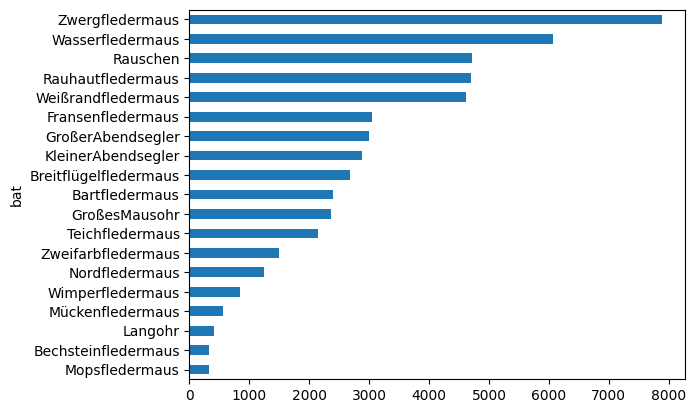

In [6]:
db_file_name = './batcallsv14.db'
# db_file_name = '/datasets/batcalls2/batcallsv14.db'

connection_str = f"sqlite:///{db_file_name}"
counts = pd.read_sql_query("SELECT bat, COUNT(*) AS count FROM batcalls GROUP BY bat;", connection_str, index_col = "bat")

counts['count'].sort_values().plot.barh(rot=0)
print("Total: ", counts['count'].sum())

Insgesamt haben wir also über 50.000 Datensätze in der Datenbank; obwohl die Datenbankdatei ingesamt nur ca. 470MiB groß ist, würde diese, eingelesen als DataFrame, über 8GB groß. Zusätzlich wollen wir zu den originalen Audiosignalen auch die erzeugten Spektrogramme speichern, und müssen die Gewichte der Neuronalen Netze im Speicher vorgehalten werden.

Um Rechenzeit und Speicher zu sparen, haben wir uns dazu entschieden, nur maximal die ersten 1500 Datensätze pro Klasse zu verwenden. Trotzdem fällt auf, das die Klassen teiweise sehr ungleich verteilt sind. Das könnte einen Hinweis darauf geben, dass es eventuell sinnvoll sein kann, den Datensatz durch synthetische Daten zu erweitern. Wie wir aber später sehen werden, war das nicht nötig.

Zunächst ist es hilfreich, jede Klasse einzeln zu betrachten. Das vereinfacht später die Auswahl des train/test/validate Splits.

In [7]:
bats = counts.index.to_numpy()
bats

array(['Bartfledermaus', 'Bechsteinfledermaus', 'Breitflügelfledermaus',
       'Fransenfledermaus', 'GroßerAbendsegler', 'GroßesMausohr',
       'KleinerAbendsegler', 'Langohr', 'Mopsfledermaus',
       'Mückenfledermaus', 'Nordfledermaus', 'Rauhautfledermaus',
       'Rauschen', 'Teichfledermaus', 'Wasserfledermaus',
       'Weißrandfledermaus', 'Wimperfledermaus', 'Zweifarbfledermaus',
       'Zwergfledermaus'], dtype=object)

Anschließend können wir die Rohdaten für jedes dieser Klassen einlesen. Das Numpy-Array mit den Sound-Daten bekommen wir standardmäßig als serialisierten Binary-Blob in einem Python-String von der Datenbank. Diesen wollen wir sofort in ein Numpy-Array umwandeln.

Außerdem führen wir einen Frequenzbandfilter auf den reinen Sounddaten aus. Da dieser Filter der einzige ist, der wirklich auf dem Rohsignal arbeitet und nicht auf den Spektogrammen, bietet es sich an, ihn sofort hier aufzurufen:

In [8]:
def butter_bandpass_filter(data, lowcut, highcut, sample_rate, order):
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

def transform_arr(data):
    data = np.load(io.BytesIO(data))
    data = data.astype(np.float32) / 2.0 ** (16-1)
    data = butter_bandpass_filter(data, 1500, 12000, 44100, 5)    
    return data

def read_dataset_for_bat(bat, limit):
    data = pd.read_sql(f"SELECT arr, target FROM batcalls WHERE bat = '{bat}' ORDER BY call LIMIT {limit}", connection_str)
    data['arr'] = data['arr'].map(transform_arr)
    return data

datasets = [read_dataset_for_bat(bat, limit = 1500) for bat in bats]

pd.DataFrame([{"bat": bat, "count": len(df)} for bat, df in zip(bats, datasets)])

,bat,count
0,Bartfledermaus,1500
1,Bechsteinfledermaus,329
2,Breitflügelfledermaus,1500
3,Fransenfledermaus,1500
4,GroßerAbendsegler,1500
5,GroßesMausohr,1500
6,KleinerAbendsegler,1500
7,Langohr,411
8,Mopsfledermaus,327
9,Mückenfledermaus,566


Auch hier kann man sehr schnell die ungleiche Verteilung der Daten erkennen.

Wir wollen die ersten 100 Datensätze pro Klasse als Test-Datensatz verwenden. Von den übrigen Daten verwenden wir die nächsten 10% als Validierungsdatensatz, und die restlichen Daten als Trainingsdaten. Dadurch stellen wir sicher, dass immer derselbe Test/Train Split erzeugt wird.

Die gesplitteten Datensätze können wir anschließend zusammenfügen und randomisieren, ohne den Split zu verändern.

In [9]:
test_data = [df.iloc[:100] for df in datasets]
validate_data = [df.iloc[100:100+len(df) // 5] for df in datasets]
train_data = [df.iloc[100+len(df)//5:] for df in datasets]

stats = pd.DataFrame([
    {"bat": bat, "test_size": len(test), "train_size": len(train), "validate_size": len(validate)}
    for (bat, test, train, validate) in zip(bats, test_data, train_data, validate_data)
])

# Datensätze zusammenfügen und mischen
test_data = pd.concat(test_data)
validate_data = pd.concat(validate_data).sample(frac = 1)
train_data = pd.concat(train_data).sample(frac = 1)

stats

,bat,test_size,train_size,validate_size
0,Bartfledermaus,100,1100,300
1,Bechsteinfledermaus,100,164,65
2,Breitflügelfledermaus,100,1100,300
3,Fransenfledermaus,100,1100,300
4,GroßerAbendsegler,100,1100,300
5,GroßesMausohr,100,1100,300
6,KleinerAbendsegler,100,1100,300
7,Langohr,100,229,82
8,Mopsfledermaus,100,162,65
9,Mückenfledermaus,100,353,113


Um die Audio-Dateien zu visualisieren, können wir jetzt pro Klasse eine Beispiel-Fledermaus auswählen. Die Sounddaten dieser Fledermaus wandeln wir im Anschluss in ein "einfaches" Spektogramm um, ohne zusätzliche Aufbereitungsschritte:

In [10]:
samples = pd.DataFrame([(bat, df.iloc[0]['arr']) for bat, df in zip(bats, datasets)], columns=['bat', 'call'])

# remove the "Rauschen" sample, since this is not really a bat.
# We will use it for training, but it's not interesting to look at in a visualisation.
samples = samples[samples['bat'] != 'Rauschen']
samples

,bat,call
0,Bartfledermaus,"[-0.0001143867424726951, -0.000488577103650947..."
1,Bechsteinfledermaus,"[0.00012103713447692156, 0.0004918040557634891..."
2,Breitflügelfledermaus,"[-0.0027519322113489088, -0.01414582989407117,..."
3,Fransenfledermaus,"[-9.310548805917043e-06, -6.113827038572975e-0..."
4,GroßerAbendsegler,"[0.00044557626428317276, 0.002111567512744846,..."
5,GroßesMausohr,"[0.00016758987850650677, 0.0008389318503575334..."
6,KleinerAbendsegler,"[-0.00043493563707641046, -0.00210800048344579..."
7,Langohr,"[1.8621097611834085e-05, 0.0001000128285329352..."
8,Mopsfledermaus,"[9.443556646001572e-05, 0.0004376638168871176,..."
9,Mückenfledermaus,"[-0.00013832815368791036, -0.00068879924849596..."


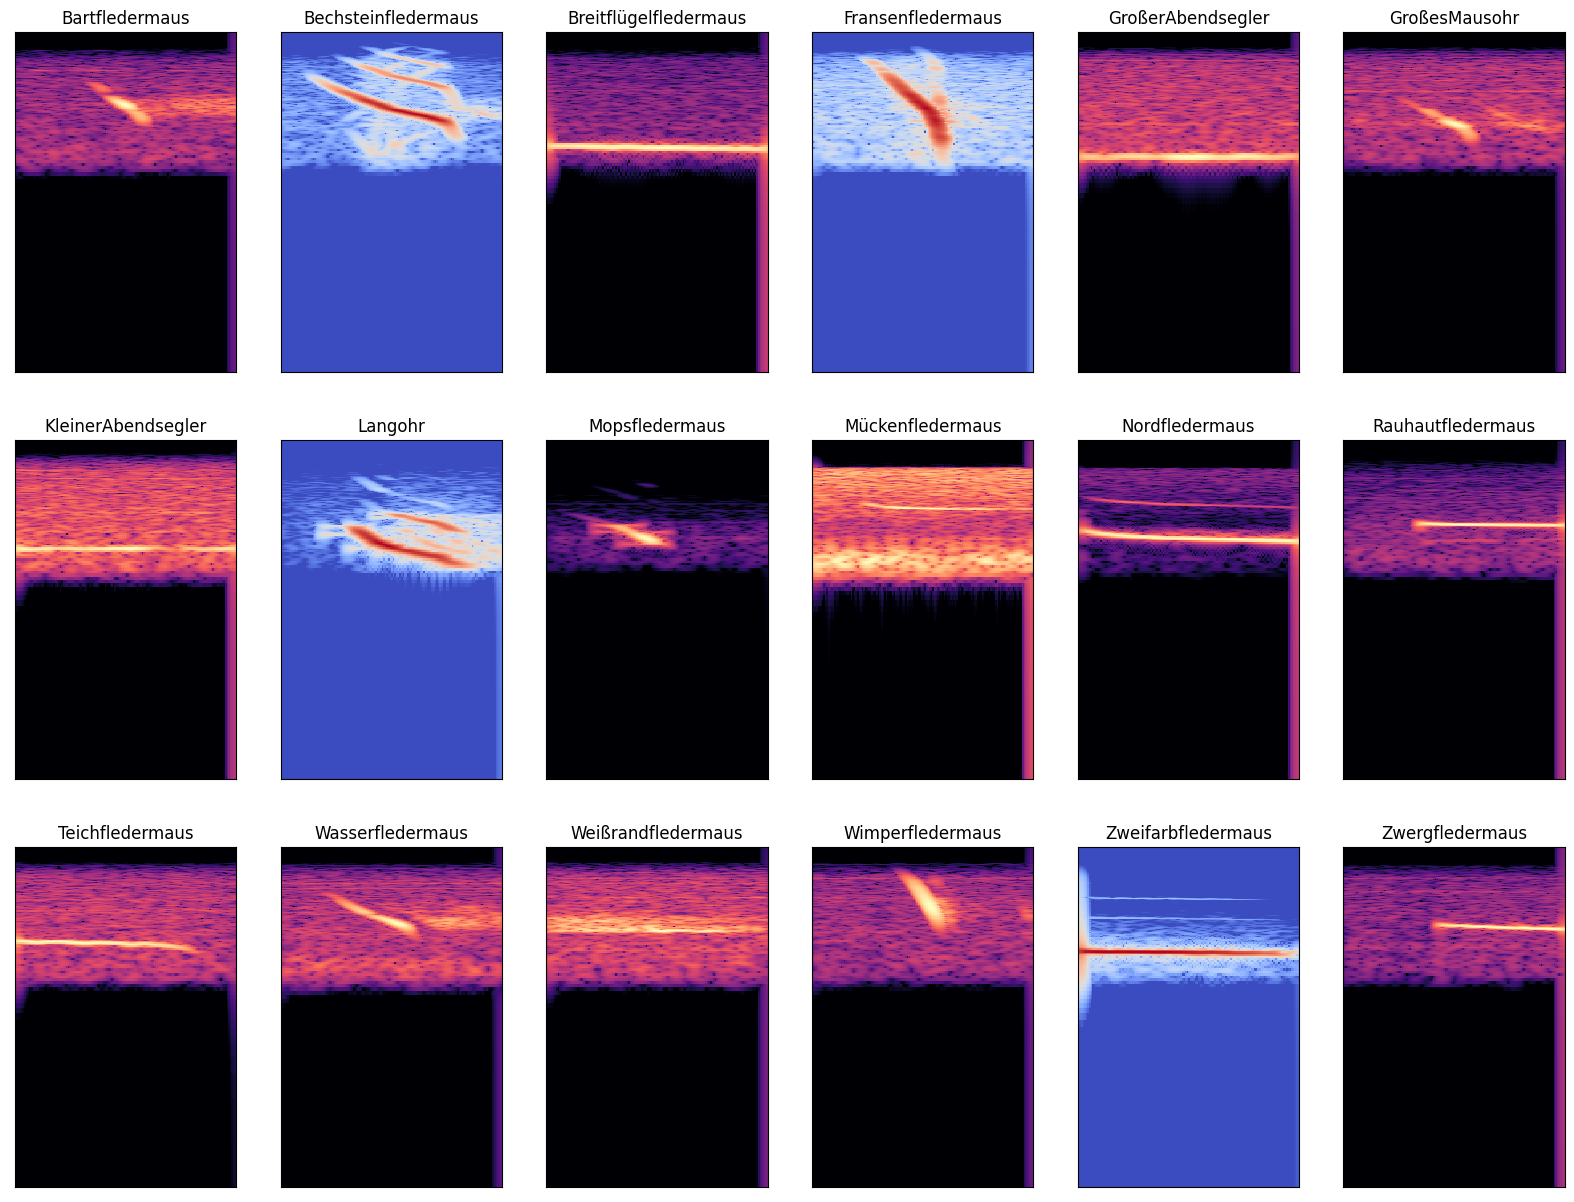

In [11]:
def simple_fft(data):
    stft = np.abs(librosa.stft(data, n_fft=512, hop_length=32))
    stft = librosa.amplitude_to_db(stft)
    return stft

fig, axs = plt.subplots(3, 6, figsize=(20,15))
for i in range(0, len(samples)):
    sample = samples.iloc[i]
    ax = axs[i // 6 , i % 6]
    fft = simple_fft(sample['call'])
    img = librosa.display.specshow(fft, y_axis='log', ax=ax, sr=44100, hop_length=32)
    ax.set_title(sample['bat'])
    ax.get_yaxis().set_visible(False)

Da wir unseren Einlesecode hier neu strukturiert haben, sind die dargestellten Bilder leider andere als in der Präsentation.

### CNN mit Originaldaten

Im Original-Code, den wir zum Verarbeiten der Daten bekommen haben, wurden die Daten aus den Spektogrammen standardisiert, indem der Mittelwert gleich 0, und die Standardabweichung auf 1 gebracht wurde. Außerdem wurde über einen eigenen Logarithmus-Aufruf, der (modulo konstantem Faktoren) ungefähr der `librosa.amplitude_to_db`-Funktion entspricht.

Die so verarbeiteten Spektrogramme sehen so aus:

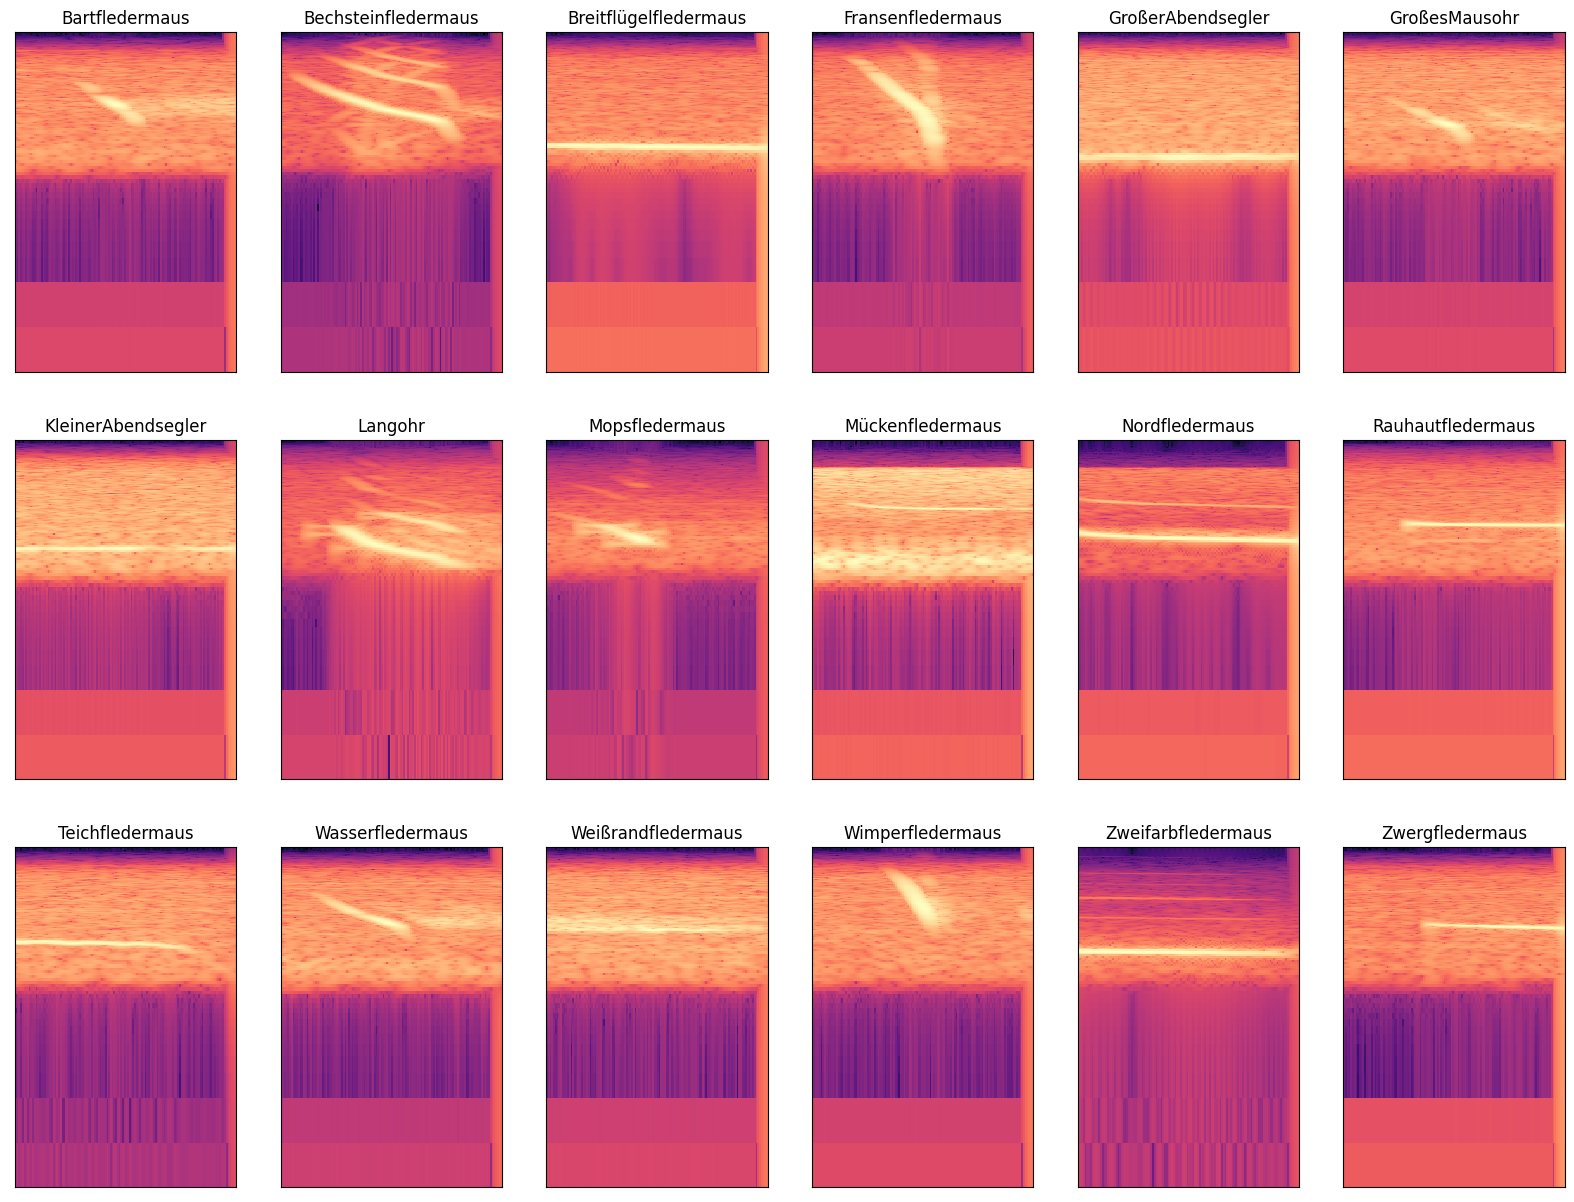

In [12]:
def orig_fft(data):
    data = (data - np.mean(data)) / np.std(data)
    stft = np.abs(librosa.stft(data, n_fft=512, hop_length=32))
    stft = np.nan_to_num(10 * np.log10(stft))
    
    lo = np.min(stft)
    hi = np.max(stft)
    if lo < hi:
        stft = (stft-lo) / (hi-lo)
        
    else:
        stft = np.zeros(stft.shape)

    stft = stft[:256, -128:]
    return stft

fig, axs = plt.subplots(3, 6, figsize=(20,15))
for i in range(0, len(samples)):
    sample = samples.iloc[i]
    ax = axs[i // 6 , i % 6]
    fft = orig_fft(sample['call'])
    img = librosa.display.specshow(fft, y_axis='log', ax=ax, sr=44100, hop_length=32)
    ax.set_title(sample['bat'])
    ax.get_yaxis().set_visible(False)

Mithilfe dieser Daten haben wir ein CNN trainiert. Um overfitting zu vermeiden, hat es gereicht, Dropout-Layer zwischen den einzelnen Convolutional Layers zwischenzuschalten.

Die Struktur des CNNs haben wir größtenteils von dem gegebenen Code übernommen, und einige Hyperparameter manuell getuned.

In [13]:
def build_cnn(input_shape, learning_rate):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2, 2, padding='same'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2, 2, padding='same'))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='sigmoid'))
    model.add(Dense(19, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

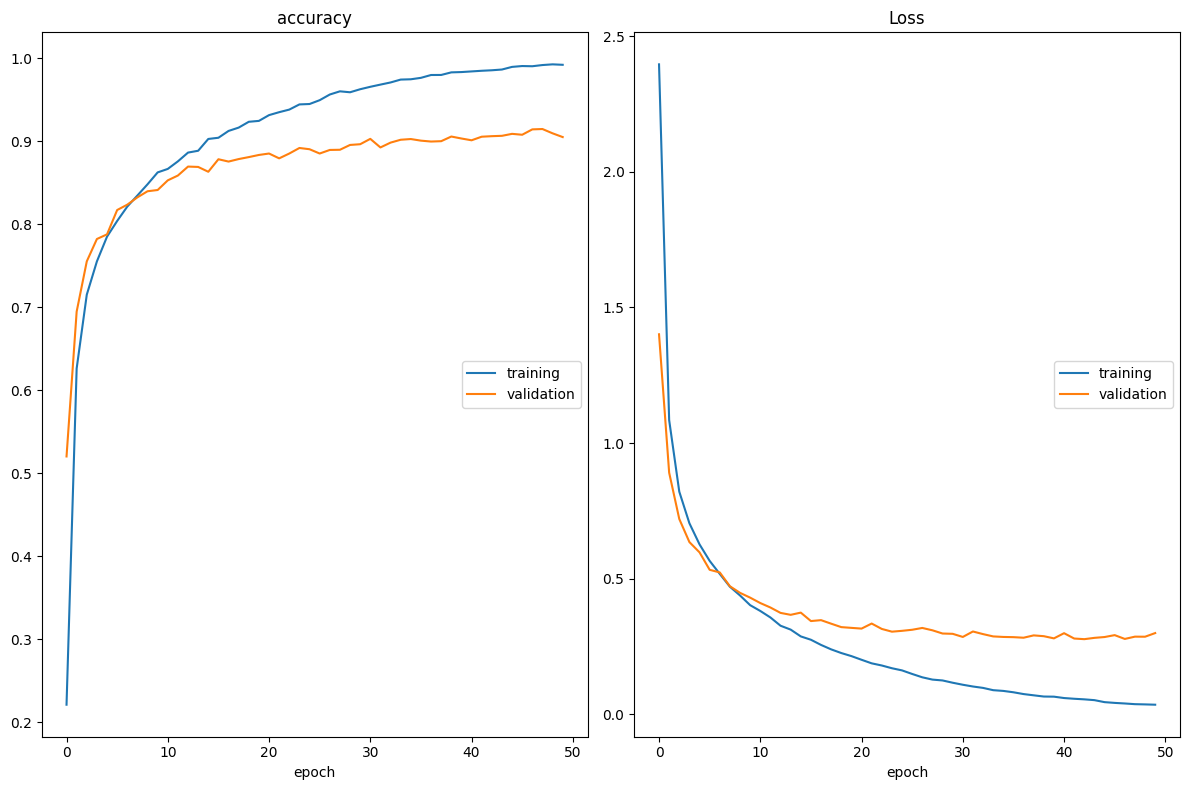

accuracy
	training         	 (min:    0.221, max:    0.992, cur:    0.992)
	validation       	 (min:    0.520, max:    0.914, cur:    0.905)
Loss
	training         	 (min:    0.036, max:    2.396, cur:    0.036)
	validation       	 (min:    0.277, max:    1.401, cur:    0.300)
522/522 [==============================] - 11s 21ms/step - loss: 0.0358 - accuracy: 0.9918 - val_loss: 0.2998 - val_accuracy: 0.9048


In [14]:
input_shape = (256, 128, 1)
model = build_cnn(input_shape, learning_rate = 0.0002)

X_train = np.concatenate(train_data['arr'].map(orig_fft).values).reshape((-1,) + input_shape)
y_train = to_categorical(train_data['target'], len(bats))

X_validate = np.concatenate(validate_data['arr'].map(orig_fft).values).reshape((-1,) + input_shape)
y_validate = to_categorical(validate_data['target'], len(bats))

model.fit(X_train, y_train,
    validation_data = (X_validate, y_validate),                              
    epochs = 50,
    verbose = 1,
    callbacks = [PlotLossesKerasTF()]
)

model.save("orig.keras")

In [15]:
# model = tf.keras.models.load_model('orig.keras')
X_test = np.concatenate(test_data['arr'].map(orig_fft).values).reshape((-1,) + input_shape)
y_test = test_data['target']

y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred, target_names=bats))

/tmp/ipykernel_279/2642969081.py:4: RuntimeWarning: divide by zero encountered in log10
  stft = np.nan_to_num(10 * np.log10(stft))


60/60 [==============================] - 1s 9ms/step
                       precision    recall  f1-score   support

       Bartfledermaus       0.94      0.91      0.92       100
  Bechsteinfledermaus       1.00      0.95      0.97       100
Breitflügelfledermaus       0.93      0.88      0.90       100
    Fransenfledermaus       0.94      0.99      0.97       100
    GroßerAbendsegler       0.95      0.93      0.94       100
        GroßesMausohr       0.91      0.96      0.94       100
   KleinerAbendsegler       0.79      0.88      0.83       100
              Langohr       1.00      0.93      0.96       100
       Mopsfledermaus       0.99      0.98      0.98       100
     Mückenfledermaus       1.00      1.00      1.00       100
       Nordfledermaus       0.96      0.94      0.95       100
    Rauhautfledermaus       0.73      0.88      0.80       100
             Rauschen       1.00      1.00      1.00       100
      Teichfledermaus       0.87      0.90      0.88       100
 

Das sieht doch schon sehr gut aus! Ein relativ einfach strukturiertes CNN, bei dem wir nur darauf achten, nicht zu overfitten, liefert mit genügend Daten bereits sehr gute Ergebnisse.

Anders als in der Präsentation haben wir hier alle Netzwerke auch noch einmal neu trainiert, und beim Einlesecode besonders darauf geachtet, dass die Splits stabil bleiben und ein anderer Seed des Zufallszahlengenerators nicht zu anderen Ergebnissen führt. Dadurch weichen auch hier die Werte etwas ab.

### CNN mit eigener Vorverarbeitung

Statt die Parameter des Netzwerks weiter zu verbessern, haben wir uns als Nächstes dazu entschieden, uns die Quelldaten genauer anzuschauen.

Dabei haben wir uns als Erstes überlegt, welche Werte im Spektogramm überhaupt Sinn machen.

Frequenzen, die eine kleinere Amplitude als 5% haben, habe ich dabei als Stille oder Hintergrundrauschen interpretiert und herausgefiltert. Dadurch wollte ich dem "lila Rauschen" in den Originaldaten entgegenwirken.

In [22]:
min_db = librosa.amplitude_to_db([0.05])[0]
min_db

-26.020599913279625

Zusätzlich wissen wir auch, dass wir am Anfang einen Frequenzbandfilter angewendet. Frequenzen außerhalb desselben Wertebereichs können also nur Artefakte der Fourier-Transformation enthalten; Auch diese wollte ich entfernen.

In [16]:
frequencies = librosa.core.fft_frequencies(sr=44100, n_fft=512)
low_index = np.argmax(frequencies > 1500)
high_index = np.argmax(frequencies > 12000)
(low_index, high_index)

(18, 140)

Unseren Beispieldatensatz können wir mit dieser Transformation visualisieren.

Zu beachten ist dabei, dass die Y-Achse nicht mehr stimmt - Da die Tonhöhe eine logarithmische Skala ist, werden die Werte nach unten auseinander gezogen. 

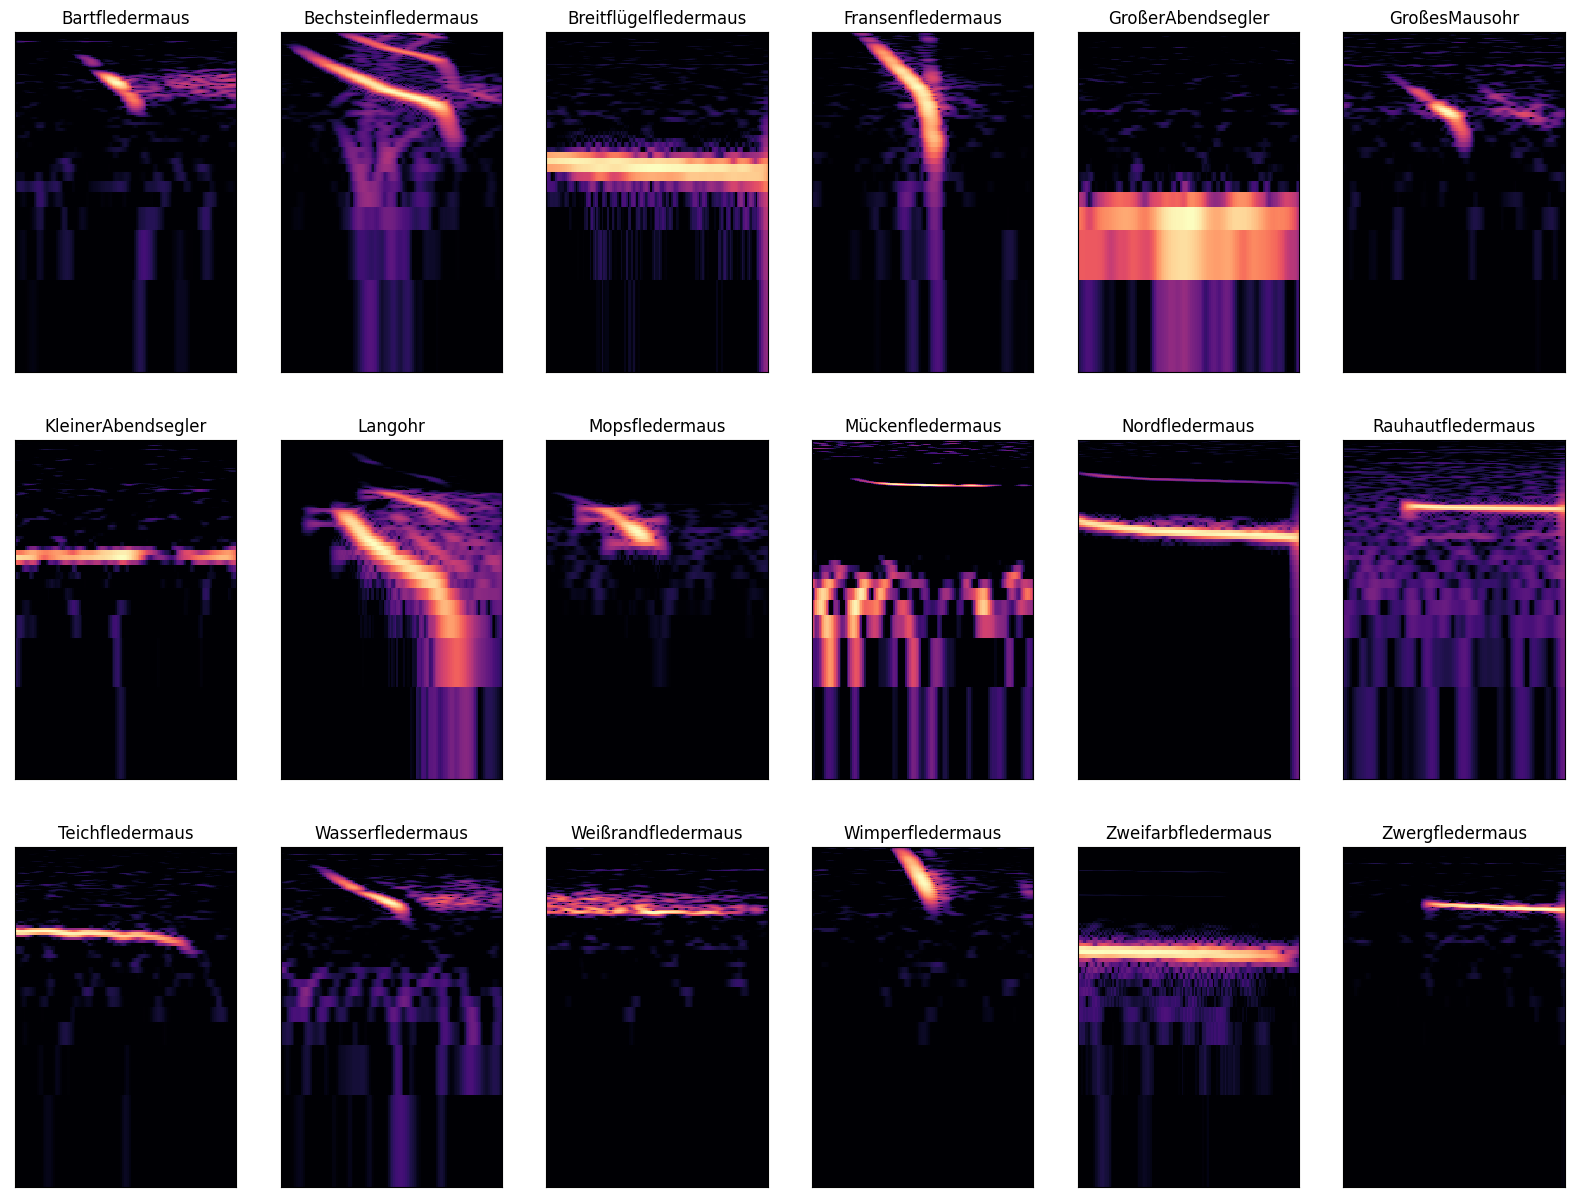

In [23]:
def my_fft(data):
    stft = np.abs(librosa.stft(data, n_fft=512, hop_length=32))
    stft = librosa.amplitude_to_db(stft)
    stft.clip(min=min_db, out=stft)
    stft = stft[low_index:high_index, -128:]
    lo = np.min(stft)
    hi = np.max(stft)
    if lo < hi:
        stft = (stft-lo) / (hi-lo)
        
    else:
        stft = np.zeros(stft.shape)

    return stft

fig, axs = plt.subplots(3, 6, figsize=(20,15))
for i in range(0, len(samples)):
    sample = samples.iloc[i]
    ax = axs[i // 6 , i % 6]
    fft = my_fft(sample['call'])
    
    img = librosa.display.specshow(fft, y_axis='log', ax=ax, sr=44100, hop_length=32)
    ax.set_title(sample['bat'])
    ax.get_yaxis().set_visible(False)

Mit diesen Daten haben wir dann dasselbe neuronale Netz trainiert:

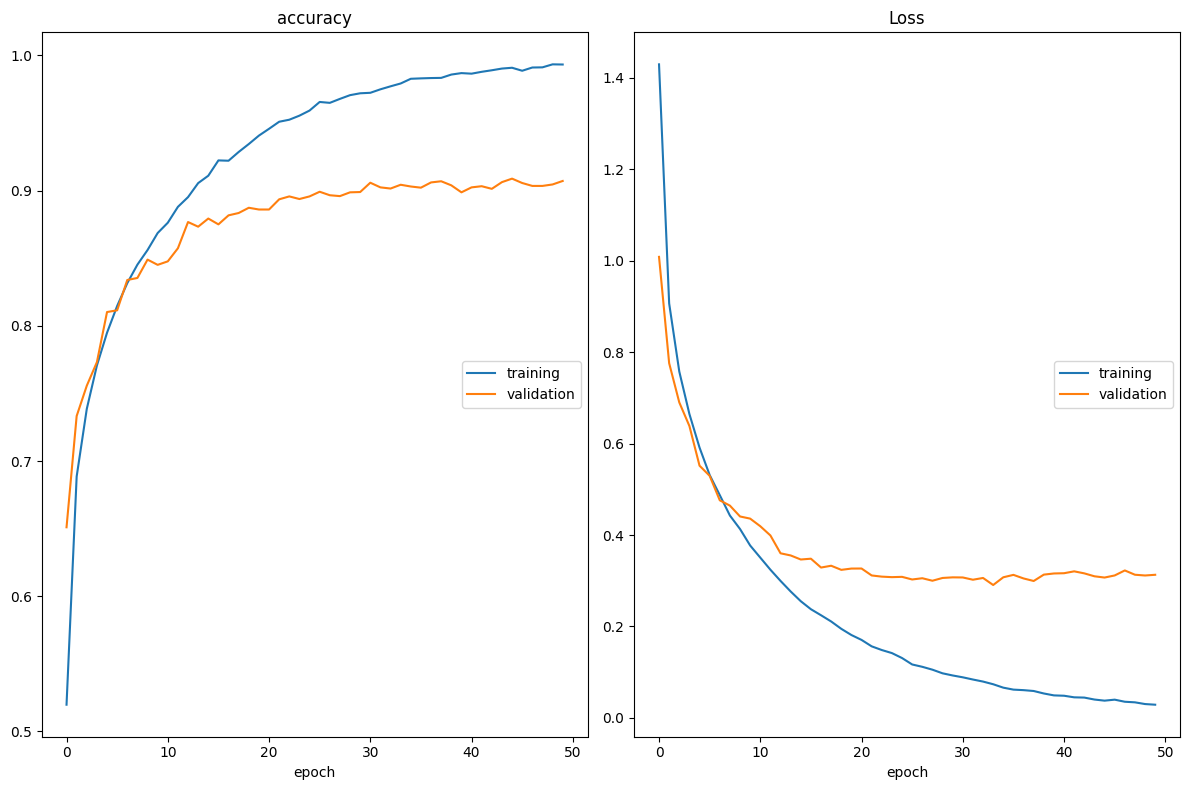

accuracy
	training         	 (min:    0.520, max:    0.993, cur:    0.993)
	validation       	 (min:    0.651, max:    0.909, cur:    0.907)
Loss
	training         	 (min:    0.029, max:    1.430, cur:    0.029)
	validation       	 (min:    0.291, max:    1.008, cur:    0.313)
522/522 [==============================] - 7s 13ms/step - loss: 0.0289 - accuracy: 0.9933 - val_loss: 0.3130 - val_accuracy: 0.9072


In [24]:
input_shape = (high_index-low_index, 128, 1)
model = build_cnn(input_shape, learning_rate = 0.0002)

X_train = np.concatenate(train_data['arr'].map(my_fft).values).reshape((-1,) + input_shape)
y_train = to_categorical(train_data['target'], len(bats))

X_validate = np.concatenate(validate_data['arr'].map(my_fft).values).reshape((-1,) + input_shape)
y_validate = to_categorical(validate_data['target'], len(bats))


model.fit(X_train, y_train,
    validation_data = (X_validate, y_validate),                              
    epochs = 50,
    verbose = 1,
    callbacks = [PlotLossesKerasTF()]
)

model.save("my.keras")

In [25]:
# model = tf.keras.models.load_model('my.keras')
X_test = np.concatenate(test_data['arr'].map(my_fft).values).reshape((-1,) + input_shape)
y_test = test_data['target']

y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred, target_names=bats))

60/60 [==============================] - 0s 5ms/step
                       precision    recall  f1-score   support

       Bartfledermaus       0.90      0.96      0.93       100
  Bechsteinfledermaus       1.00      0.95      0.97       100
Breitflügelfledermaus       0.91      0.85      0.88       100
    Fransenfledermaus       0.95      0.96      0.96       100
    GroßerAbendsegler       0.93      0.95      0.94       100
        GroßesMausohr       0.96      0.97      0.97       100
   KleinerAbendsegler       0.86      0.89      0.87       100
              Langohr       0.99      0.91      0.95       100
       Mopsfledermaus       1.00      1.00      1.00       100
     Mückenfledermaus       1.00      1.00      1.00       100
       Nordfledermaus       0.92      0.94      0.93       100
    Rauhautfledermaus       0.87      0.78      0.82       100
             Rauschen       1.00      1.00      1.00       100
      Teichfledermaus       0.87      0.96      0.91       100
 

Das hat leider keine Verbesserung gebracht. Aber obwohl wir über die Hälfte der Werte abgeschnitten haben, hat sich die Genauigkeit des CNN auch nicht verschlechtert! Wir haben also keine "wichtigen" Werte abgeschnitten.

### Manuelle Dimensionsreduktion

Zuletzt haben wir uns überlegt, ob man auch durch Domain-spezifisches Wissen die Dimensionaliät der Daten manuell reduzieren kann, ohne darauf angewiesen zu sein, dass ein CNN die nötige Transformation lernt.

Unser Ansatz war dabei, die Schreie von Fledermäusen ähnlich zu menschlischen Stimmen zu modellieren; das heißt wir gehen davon aus, dass verschiedene Fledermausarten anders klingen, und im Durchschnitt ihr Schrei immer in einer ähnlichen Melodie und Dynamik folgt.

Wir haben also statt eines Spektogramm 3 Zeitreihen-Features:

- **Die Tonhöhe:** Die lauteste Frequenz ist üblicherweise die, die als Tonhöhe wargenommen wird.
- **Die Lautstärke:** Aus mathematischen Gründen verwenden die durchschnittliche Lautstärke. Möglich könnte auch sein, die Summe zu verwenden.
- **Die Stimmfarbe:** Verschiedene Stimmen entstehen bei Menschen durch unterschiedliche Resonanzen im Rachen-, Mund-, und Nasenbereich. Diese führen zu unterschiedlich lauten und verschieden verteilten Ober- und Untertönen. Diese unterschiedliche Verteilung wollen wir über die Varianz/Standardabweichung der Lautstärke modellieren.

Wir können die erkannte Lautstärke und Tonhöhe wieder auf unseren Testdaten veranschaulichen:

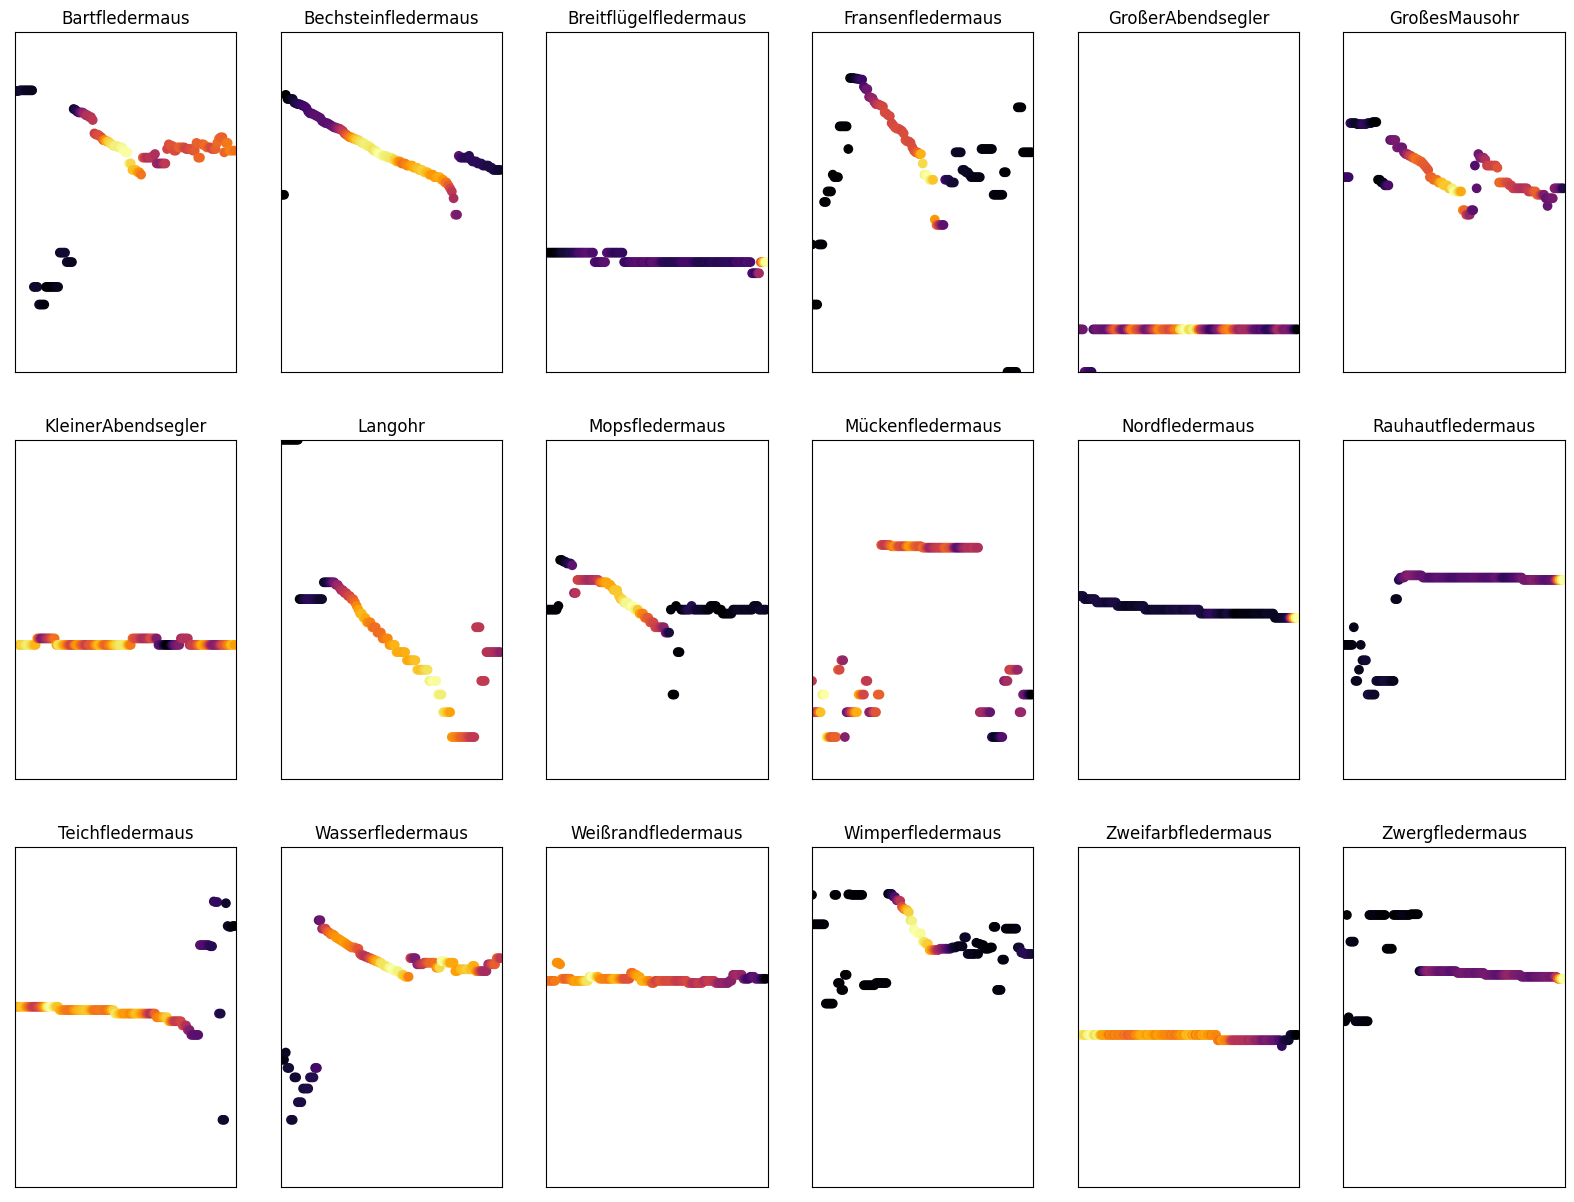

In [26]:
# see https://stackoverflow.com/questions/63350459/getting-the-frequencies-associated-with-stft-in-librosa
notes = librosa.core.hz_to_midi(librosa.core.fft_frequencies(sr=44100, n_fft=512)[1:])
notes = (notes - np.min(notes)) / (np.max(notes) - np.min(notes))

def transform_means(call):
    call = my_fft(call)
    return np.apply_along_axis(lambda call: [
        np.mean(call),
        np.std(call),
        notes[np.argmax(call) - 1],
    ], 0, call)

fig, axs = plt.subplots(3, 6, figsize=(20,15))
for i in range(0, len(samples)):
    sample = samples.iloc[i]
    ax = axs[i // 6 , i % 6]

    values = transform_means(sample['call'])
    # ax.set_yscale('log')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.scatter(np.arange(0, 128) / 128, values[2,:], c=values[0,:],cmap="inferno")
    ax.set_title(sample['bat'])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


### FFNN

Mit diesen Daten haben verschiedene Möglichkeiten zur Klassifikation ausprobiert. Zunächst haben wir ein einfaches Feed-Forward Netzwerk versucht:

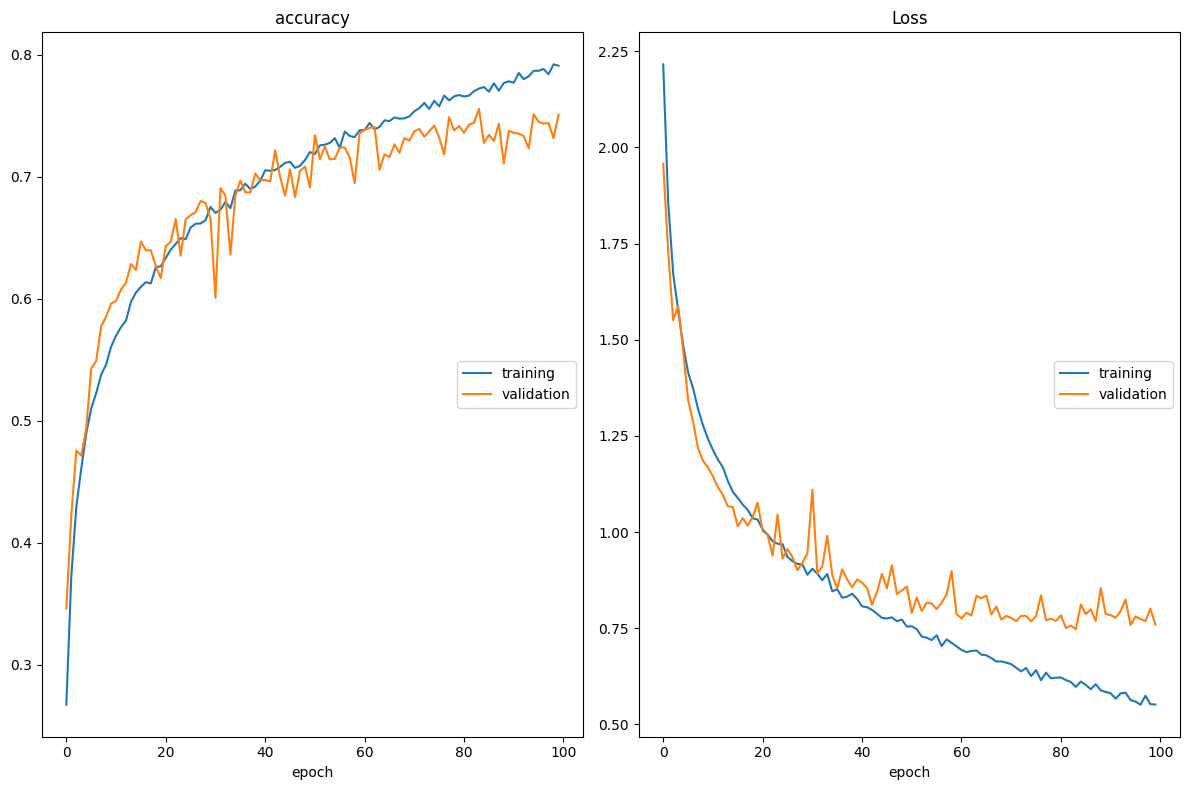

accuracy
	training         	 (min:    0.267, max:    0.792, cur:    0.791)
	validation       	 (min:    0.346, max:    0.756, cur:    0.751)
Loss
	training         	 (min:    0.551, max:    2.216, cur:    0.552)
	validation       	 (min:    0.747, max:    1.958, cur:    0.760)
261/261 [==============================] - 2s 6ms/step - loss: 0.5517 - accuracy: 0.7909 - val_loss: 0.7597 - val_accuracy: 0.7508


In [29]:
X_train = np.concatenate(train_data['arr'].map(transform_means).values).reshape((-1, 128 * 3))
y_train = to_categorical(train_data['target'], len(bats))

X_validate = np.concatenate(validate_data['arr'].map(transform_means).values).reshape((-1, 128 * 3))
y_validate = to_categorical(validate_data['target'], len(bats))

# Erstellen des Modells
model = Sequential()
model.add(Dense(128 * 3, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128 * 3, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128 * 3, activation='sigmoid'))
model.add(Dense(19, activation='softmax'))

myAdam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Kompilieren des Modells
model.compile(optimizer=myAdam, loss='categorical_crossentropy', metrics=['accuracy'])
#Modell trainieren
model.fit(X_train, y_train, 
          validation_data=(X_validate, y_validate),                              
          epochs=100,
          batch_size=64,
          verbose=1,
          callbacks=[PlotLossesKerasTF()])

In [30]:
model.save("ffnn.keras")

In [31]:
# model = tf.keras.models.load_model('ffnn.keras')
X_test = np.concatenate(test_data['arr'].map(transform_means).values).reshape((-1, 128 * 3))
y_test = test_data['target']

y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred, target_names=bats))

60/60 [==============================] - 0s 2ms/step
                       precision    recall  f1-score   support

       Bartfledermaus       0.58      0.76      0.66       100
  Bechsteinfledermaus       0.95      0.94      0.94       100
Breitflügelfledermaus       0.71      0.72      0.72       100
    Fransenfledermaus       0.78      0.82      0.80       100
    GroßerAbendsegler       0.88      0.84      0.86       100
        GroßesMausohr       0.76      0.78      0.77       100
   KleinerAbendsegler       0.54      0.66      0.59       100
              Langohr       0.95      0.88      0.91       100
       Mopsfledermaus       0.99      0.95      0.97       100
     Mückenfledermaus       0.95      0.79      0.86       100
       Nordfledermaus       0.85      0.75      0.80       100
    Rauhautfledermaus       0.64      0.69      0.67       100
             Rauschen       0.98      1.00      0.99       100
      Teichfledermaus       0.72      0.62      0.67       100
 

Trotz des einfachen Aufbau des Netzwerks werden für einige Klassen sehr gute Werte erreicht!

Der Verlauf der accuracy/loss Graphen lässt vermuten, dass eventuell ein leichtes Overfitting stattfindet und auch die Hyperparameter noch besser gewählt werden könnten. Trotzdem erreicht das Netzwerk auch auf den Testdaten bei vielen Klassen relativ gute Werte, besonders relativ zur Komplexität dieses Ansatzes verglichen mit einem CNN.

### PCA

Da das FFNN schon gute Ergebnisse lieferte, haben wir noch andere einfachere Verfahren auf unseren so transformierten Daten versucht. Eine einfache andere Möglichkeit zur Klassifikation, mit der wir uns auch schon auf den Originaldaten bschäftigt haben, ist die Hauptkomponentenanalyse.

In [ ]:
# Falls die Werte vom FFNN nicht mehr vorhanden sind:
X_train = np.concatenate(train_data['arr'].map(transform_means).values).reshape((-1, 128 * 3))

1 Hauptkomponente(n): 0.46653754882350695 variance explained
2 Hauptkomponente(n): 0.6213070539474289 variance explained
3 Hauptkomponente(n): 0.6723191830538049 variance explained
5 Hauptkomponente(n): 0.7330339699824044 variance explained
10 Hauptkomponente(n): 0.8130094199283572 variance explained
19 Hauptkomponente(n): 0.8878962409621898 variance explained
100 Hauptkomponente(n): 0.9870911795747436 variance explained
2 Hauptkomponenten: [0.46653755 0.15476951]


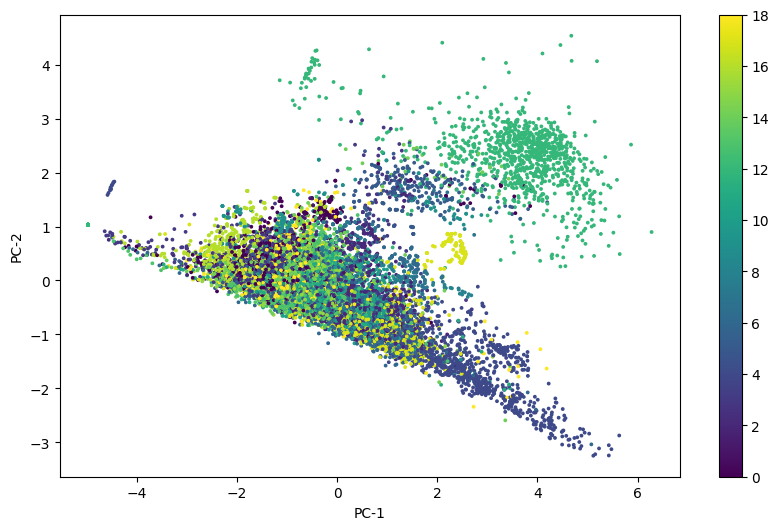

3 Hauptkomponenten [0.46653755 0.15476951 0.05101213]


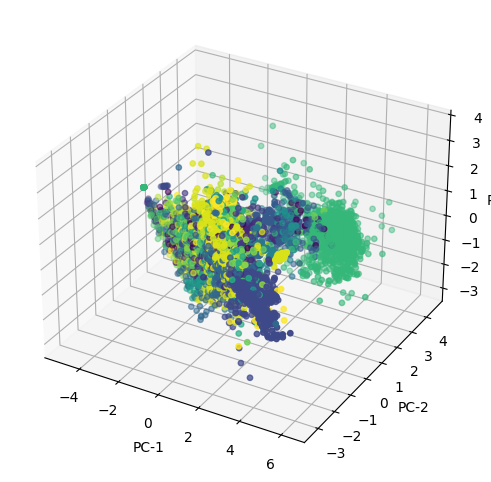

In [37]:
y_train = train_data['target']

dims = [1, 2, 3, 5, 10, len(bats), 100]
pcas = []
transformed = []
for dim in dims:
    pca = PCA(n_components=dim)
    pcas.append(pca)
    transformed.append(pca.fit_transform(X_train))
    print(f"{dim} Hauptkomponente(n): {sum(pca.explained_variance_ratio_)} variance explained")

pca_2d = pcas[1]
X_2d = transformed[1]
print("2 Hauptkomponenten:", pca_2d.explained_variance_ratio_)

plt.figure(figsize = (10,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s = 3, c = y_train)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

pca_3d = pcas[2]
X_3d = transformed[2]
print("3 Hauptkomponenten", pca_3d.explained_variance_ratio_)



fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], s = 15, c = y_train)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')

plt.show()

Während mit 2 Hauptkomponenten wieder nur das Rauschen klar separiert ist, sieht das Ganze bei 3 Dimensionen besser aus; Wir verwenden dieselbe KNN-Klassifizierung um die Werte zu vergleichen:

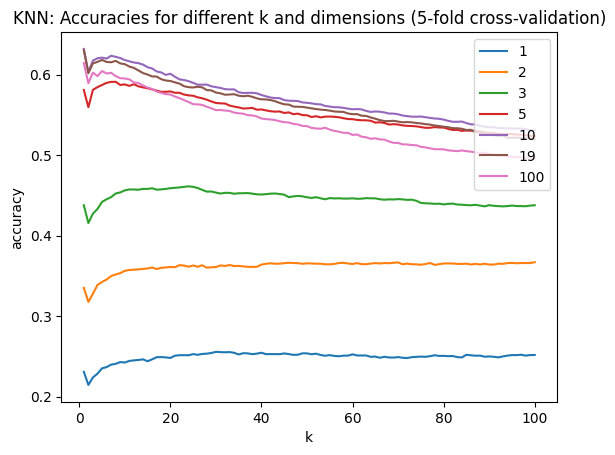

In [38]:
# KNN mit k zwischen 1 und 100 auf den transformierten Daten. LLOCV wäre gut, da deterministische Ergebnisse, dauert aber zu lange, deshalb CV 
# mit 5 Splits. Als Ergebnis wird der Durchschnitt der jeweiligen Accuracies verwendet

k = range(1, 101)
scores_knn = []

for i, pca_data in enumerate(transformed):
    scores_knn.append([])
    for n_neighbors in k:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        scores = cross_validate(knn, pca_data, y_train)
        scores_knn[i].append(np.mean(scores["test_score"]))

# Visualisierung der Ergebnisse
for elem in scores_knn:
    plt.plot(k, elem, label=dims[scores_knn.index(elem)])
plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend(loc="upper right")
plt.title("KNN: Accuracies for different k and dimensions (5-fold cross-validation)")
plt.show()

Leider konnten wir hier nicht dieselbe Performance erreichen; wir haben uns deshalb dazu entschlossen, diese Idee nicht mehr weiter zu verfolgen.